In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from surgeNN.models import build_ConvLSTM2D_with_channels
from surgeNN.io import load_predictand,load_predictors
from surgeNN.utils import plot_loss_evolution, get_train_test_val_idx, normalize_timeseries, rmse, sequenced_dataset_from_dataset
from sklearn.metrics import confusion_matrix
from target_relevance import TargetRelevance #first, in terminal, do->'mamba install kdepy'

2024-05-07 14:37:16.843836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load in & preprocess data:

In [3]:
tg = 'den_helder-denhdr-nld-rws.csv' #site to predict
predictand   = load_predictand('/home/jovyan/test_surge_models/input/t_tide_3h_anoms_deseasoned_predictands',tg) #open predictand csv (with mean seasonal cycle removed)
#predictand   = load_predictand('/Users/timhermans/Documents/Github/surgeNN/input/predictands_6hourly',tg) #open predictand csv
predictors   = load_predictors('/home/jovyan/test_surge_models/input/predictors_3hourly',tg,5) #open predictor xarray dataset
predictors   = predictors.sel(time=slice('1980','2016')) #period for which we have hydrodynamic output as well

# only use predictands at timesteps for which we have predictor values:
predictand = predictand[(predictand['date']>=predictors.time.isel(time=0).values) & (predictand['date']<=predictors.time.isel(time=-1).values)] 

#preprocess predictors
predictors = predictors.sel(time=predictand['date'].values)
predictors = (predictors-predictors.mean(dim='time'))/predictors.std(dim='time',ddof=0) #normalize each variable in dataset
my_predictors = np.stack((predictors.msl.values,predictors.w.values,predictors.u10.values,predictors.v10.values),axis=-1) #load into memory

#preprocess observations
predictand['surge'] = predictand['surge'].rolling(window=5,min_periods=1,center=True).mean() #in the literature, 12h-rolling means are used to account for spurious tidal peaks. Trying this out at the moment.
predictand['surge'] = normalize_timeseries(predictand['surge']) #normalize predictands
surge_obs = predictand['surge'].values #get values as array

n_steps = 8 #number of timesteps included at and before the time of the observation
batch_size = 128

idx_train,idx_test,idx_val = get_train_test_val_idx(my_predictors,surge_obs,[.6,.2,.2],shuffle=False) #split data into training, validation and testing and get indices

target_relevance = TargetRelevance(surge_obs[np.append(idx_train,idx_val)], alpha=4) #determine DenseLoss weights (apply KDE and compute inverse density weights)
weights = target_relevance.eval(surge_obs[np.append(idx_train,idx_val)]).flatten()

TargetRelevance alpha: 4
Using Silverman Bandwidth 0.11164234224478356


Create generator datasets with sequences that don't fit into memory otherwise:

In [ ]:
#xx_train=tuple([sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(predictors[k].values[idx_train,...]), n_steps, batch_size) for k in ['msl','w','u10','v10']]) #if passing variables separately
xx_train = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(my_predictors[idx_train,...]), n_steps, batch_size) #if passing variables together as channels
yy_train = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(surge_obs[idx_train][n_steps-1::]), 1, batch_size)
ww_train = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(weights[idx_train][n_steps-1::]), 1, batch_size)
zz_train = tf.data.Dataset.zip((xx_train,yy_train,ww_train))

#xx_val=tuple([sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(predictors[k].values[idx_val,...]), n_steps, batch_size) for k in ['msl','w','u10','v10']]) #if passing variables separately
xx_val = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(my_predictors[idx_val,...]), n_steps, batch_size) #if passing variables together as channels
yy_val = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(surge_obs[idx_val][n_steps-1::]), 1, batch_size)
ww_val = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(weights[idx_val][n_steps-1::]), 1, batch_size)
zz_val = tf.data.Dataset.zip((xx_val,yy_val,ww_val))

#xx_test=tuple([sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(predictors[k].values[idx_test,...]), n_steps, batch_size) for k in ['msl','w','u10','v10']]) #if passing variables separately
xx_test = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(my_predictors[idx_test,...]), n_steps, batch_size) #if passing variables together as channels
yy_test = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(surge_obs[idx_test][n_steps-1::]), 1, batch_size)
zz_test = tf.data.Dataset.zip((xx_test,yy_test))

Plot KDE weights:

```python
plt.figure()
plt.scatter(surge_obs[np.append(idx_train,idx_val)],weights,s=2)
plt.axhline(y=0)
plt.ylabel('Loss weight')
plt.xlabel('Sea level [standard deviation]')
plt.title('DenseLoss (KDE)')
```

In [ ]:
model = build_ConvLSTM2D_with_channels(1, 2, [32], [32,32], n_steps,20,20, 4, 'model0', .1, 1e-5, 'mae',l2=0.01)

In [ ]:
history = model.fit(zz_train,epochs=70,validation_data=zz_val,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                        restore_best_weights=True)])

In [ ]:
surge_cnn_test = model.predict(xx_test,verbose=0).flatten() #if using stacked instead of list of predictor input

If using list of predictors as input:
```python
surge_cnn_test = model.predict(tf.data.Dataset.zip((xx_test, )),verbose=0).flatten() 
```

---CNN---
bulk correlation r=0.8367202596697499
bulk RMSE=0.6315518084263132
Confusion matrix exceedances above 98th percentile:
[[20342   269]
 [   70   351]]
Correlation at timesteps where observations above 98th percentile:
r=0.8195084481707252
RMSE at timesteps where observations above 98th percentile:
RMSE=0.5591213454265016


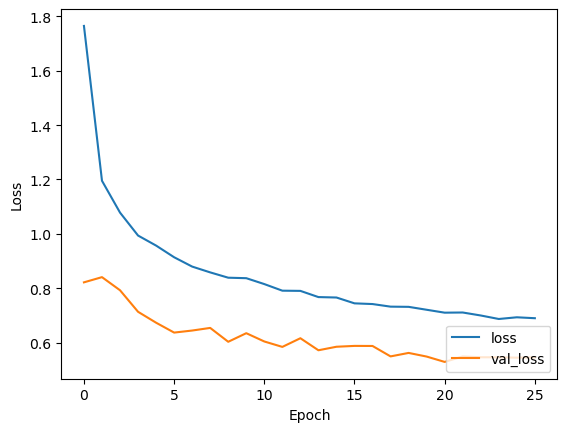

In [6]:
f = plot_loss_evolution(history) #plot training loss

### do some evaluation
threshold_pct = 98 #percentile of storm surge data to look at

surge_obs_test = surge_obs[idx_test][n_steps-1::]
threshold_value = np.percentile(surge_obs[idx_test][n_steps-1::],threshold_pct) #threshold value

surge_obs_test_exceedances = (surge_obs[idx_test][n_steps-1::]>=threshold_value).flatten() #find where storm surges exceed threshold (extremes), for observations
surge_cnn_test_exceedances = (surge_cnn_test>=threshold_value).flatten() #find where storm surges exceed threshold (extremes), for predictions with CNN

print('---CNN---')
print('bulk correlation r='+str(np.corrcoef(surge_cnn_test,surge_obs_test)[0][1]))
print('bulk RMSE='+str(rmse(surge_cnn_test,surge_obs_test)))
print('Confusion matrix exceedances above {0}th percentile:'.format(threshold_pct))
print(confusion_matrix(surge_obs_test_exceedances,surge_cnn_test_exceedances))

print('Correlation at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('r=' + str(np.corrcoef(surge_cnn_test[surge_obs_test_exceedances],surge_obs_test[surge_obs_test_exceedances])[0][1]))
print('RMSE at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('RMSE=' + str(rmse(surge_cnn_test[surge_obs_test_exceedances],surge_obs_test[surge_obs_test_exceedances])))


Some prior results:

a=3
---CNN---
bulk correlation r=0.8146921014924382
bulk RMSE=0.6628850423328566
Confusion matrix exceedances above 98th percentile:
[[20416   195]
 [  120   301]]
Correlation at timesteps where observations above 98th percentile:
r=0.833167212453055
RMSE at timesteps where observations above 98th percentile:
RMSE=0.6235710888040278

a=4
---CNN---
bulk correlation r=0.8336205641066491
bulk RMSE=0.6346390808066679
Confusion matrix exceedances above 98th percentile:
[[20251   360]
 [   64   357]]
Correlation at timesteps where observations above 98th percentile:
r=0.8399073757669463
RMSE at timesteps where observations above 98th percentile:
RMSE=0.5186600518141902

---CoDEC---
bulk correlation r=0.9271770349293676
bulk RMSE=0.3521273103012632
Confusion matrix exceedances above 98th percentile:
[[20508   103]
 [   70   351]]
Correlation at timesteps where observations above 98th percentile:
r=0.9168742281823624
RMSE at timesteps where observations above 98th percentile:
RMSE=0.39142061574991016

kde weighting, rolling mean window of 5, 8 lag, 128 batch size, model = test_model(1, 2, [32], [32,32], n_steps,20,20, 4, 'model0', .1, 1e-5, 'mae',l2=0.01)

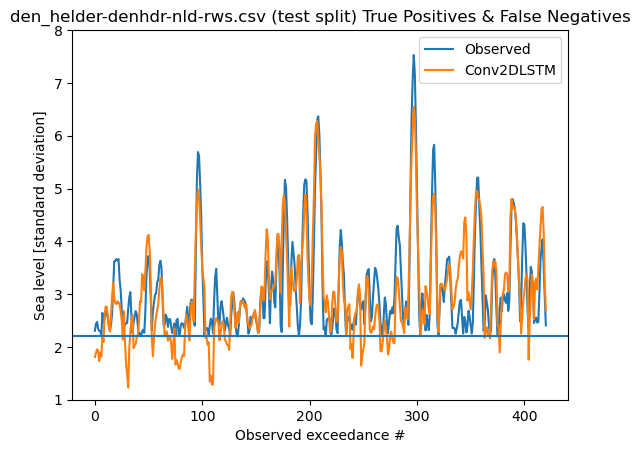

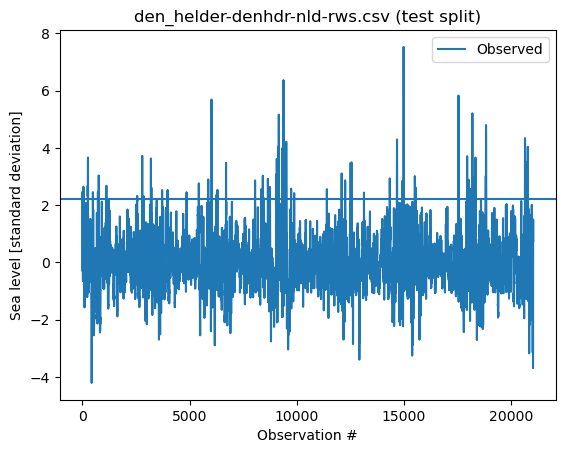

In [7]:
plt.figure()
plt.plot(surge_obs[idx_test][n_steps-1::][surge_obs_test_exceedances],label='Observed')
plt.plot(surge_cnn_test[surge_obs_test_exceedances],label='Conv2DLSTM')
plt.axhline(y=threshold_value)
plt.legend()
plt.ylabel('Sea level [standard deviation]')
plt.xlabel('Observed exceedance #')
plt.title(tg+' (test split) True Positives & False Negatives')
plt.ylim([1,8])
            

plt.figure()
plt.plot(surge_obs[idx_test][n_steps-1::],label='Observed')
#plt.plot(surge_cnn_test,label='Conv2DLSTM')
plt.axhline(y=threshold_value)
plt.ylabel('Sea level [standard deviation]')
plt.xlabel('Observation #')
plt.title(tg+' (test split)')
plt.legend()

(-2.0, 8.0)

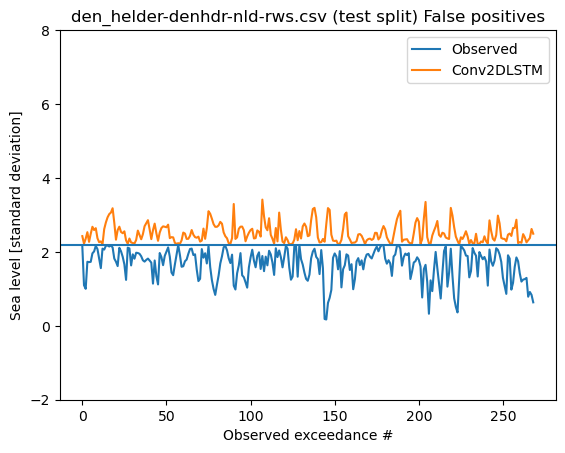

In [8]:
plt.figure()
plt.plot(surge_obs[idx_test][n_steps-1::][surge_cnn_test_exceedances * (surge_obs_test_exceedances==0)],label='Observed')
plt.plot(surge_cnn_test[surge_cnn_test_exceedances * (surge_obs_test_exceedances==0)],label='Conv2DLSTM')
plt.axhline(y=threshold_value)
plt.legend()
plt.ylabel('Sea level [standard deviation]')
plt.xlabel('Observed exceedance #')
plt.title(tg+' (test split) False positives')
plt.ylim([-2,8])

Evaluate the hydrodynamic model output samples the same timesteps as the predictands:

In [9]:
surge_codec = xr.open_dataset('/home/jovyan/test_surge_models/CoDEC_ERA5_at_gesla3_tgs_eu_hourly_anoms.nc')
surge_codec = surge_codec.sel(time=predictand['date'].values)
surge_codec['surge'] = surge_codec['surge'].rolling(time=5,min_periods=1,center=True).mean()
surge_codec['surge'] = (surge_codec['surge'] - surge_codec['surge'].mean(dim='time'))/surge_codec['surge'].std(dim='time',ddof=0) #normalize
surge_codec_test = surge_codec.sel(tg=tg).sel(time=predictand['date'].values[idx_test][n_steps-1::]).surge.values #select test timesteps
surge_codec_test_exceedances = (surge_codec_test>=threshold_value).flatten() #find where exceeding threshold
 
print('---CoDEC---')
print('bulk correlation r='+str(np.corrcoef(surge_codec_test,surge_obs_test)[0][1]))
print('bulk RMSE='+str(rmse(surge_codec_test,surge_obs_test)))
print('Confusion matrix exceedances above {0}th percentile:'.format(threshold_pct))
print(confusion_matrix(surge_obs_test_exceedances,surge_codec_test_exceedances))

print('Correlation at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('r=' + str(np.corrcoef(surge_codec_test[surge_obs_test_exceedances],surge_obs_test[surge_obs_test_exceedances])[0][1]))
print('RMSE at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('RMSE=' + str(rmse(surge_codec_test[surge_obs_test_exceedances],surge_obs_test[surge_obs_test_exceedances])))


---CoDEC---
bulk correlation r=0.9271770349293676
bulk RMSE=0.3521273103012632
Confusion matrix exceedances above 98th percentile:
[[20508   103]
 [   70   351]]
Correlation at timesteps where observations above 98th percentile:
r=0.9168742281823624
RMSE at timesteps where observations above 98th percentile:
RMSE=0.39142061574991016


(1.0, 8.0)

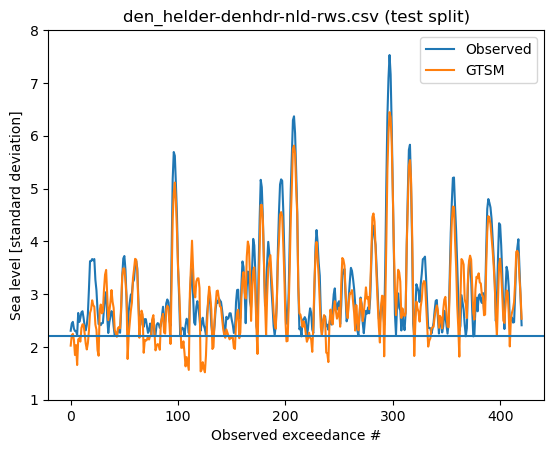

In [11]:
plt.figure()
plt.plot(surge_obs[idx_test][n_steps-1::][surge_obs_test_exceedances],label='Observed')
plt.plot(surge_codec_test[surge_obs_test_exceedances],label='GTSM')
plt.axhline(y=threshold_value)
plt.legend()
plt.ylabel('Sea level [standard deviation]')
plt.xlabel('Observed exceedance #')
plt.title(tg+' (test split)')
plt.ylim([1,8])